In [7]:
import numpy as np
import pandas as pd
import mne
from matplotlib import pyplot as plt

from helpers import map_ft9, map_ft10, map_avg

In [106]:
def plot_distribution(data1, data2, bins=500 , return_distributions=False, data_labels=None):
    if data_labels==None:
        data_labels = ["Data1", "Data2"]
    plt.hist(data1, bins=bins, density=True)
    plt.hist(data2, bins=bins, density=True)
    # plt.plot(bins1[:-1], distribution1)
    # plt.plot(bins2[:-1], distribution2)
    # plt.xlim([-1000, 1000])
    plt.legend(data_labels)
    plt.show()
    if return_distributions == True:
        raise NotImplementedError
        # return distribution1, distribution2
    

In [98]:
bins = 500

In [9]:
seizure_data_ft9 = pd.read_csv("seizure_data_ft9.csv", header=None)
non_seizure_data_ft9 = pd.read_csv("non_seizure_data_ft9.csv", header=None)

In [10]:
print(f"Mean of the seizure dataset:{np.mean(seizure_data_ft9.to_numpy()):.4f}")
print(f"Variance of the seizure dataset:{np.var(seizure_data_ft9.to_numpy()):.4f}")

print(f"Mean of the non-seizure dataset:{np.mean(non_seizure_data_ft9.to_numpy()):.4f}")
print(f"Variance of the non-seizure dataset:{np.var(non_seizure_data_ft9.to_numpy()):.4f}")


Mean of the seizure dataset:0.3778
Variance of the seizure dataset:31703.8589
Mean of the non-seizure dataset:0.1677
Variance of the non-seizure dataset:5967.3178


[]

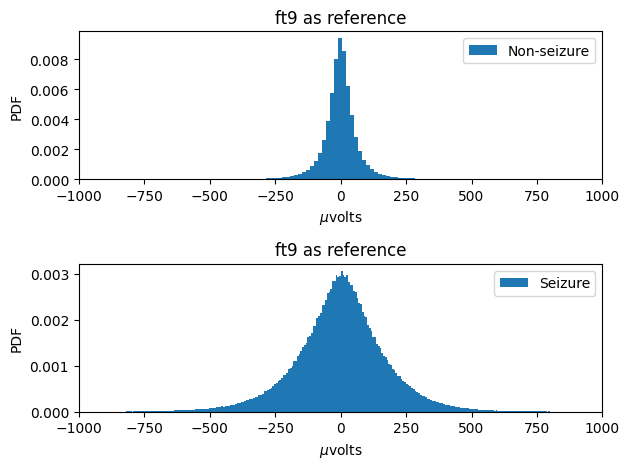

In [11]:
plt.subplot(2,1,1)
plt.hist(non_seizure_data_ft9, bins=bins, label="Non-seizure", density=True)
plt.xlim([-1000, 1000])
plt.legend()
plt.title("ft9 as reference")
plt.xlabel("$\mu$volts")
plt.ylabel("PDF")

plt.subplot(2,1,2)
plt.hist(seizure_data_ft9, bins=bins, label="Seizure", density=True)
plt.xlim([-1000, 1000])
plt.legend()
plt.title("ft9 as reference")
plt.xlabel("$\mu$volts")
plt.ylabel("PDF")
plt.tight_layout()
plt.plot()

# Trying to compute the shannon entropy on the data series

In [21]:
seizure_distribution, bins1 = np.histogram(seizure_data_ft9, bins=bins, density=True)
non_seizure_distribution, bins2 = np.histogram(non_seizure_data_ft9, bins=bins, density=True)

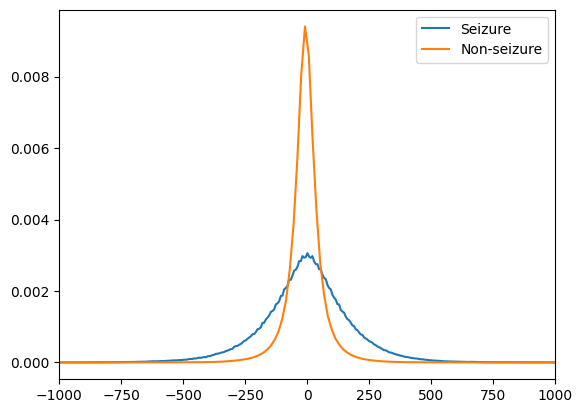

In [27]:
plt.plot(bins1[:-1], seizure_distribution)
plt.plot(bins2[:-1], non_seizure_distribution)
plt.xlim([-1000, 1000])
plt.legend(["Seizure", "Non-seizure"])

## Obesevations
- Mean overlap
- Seizure has high variance
- Non-seizure has low variance

In [28]:
# Entropy on the entire dataset
from scipy.stats import entropy

In [29]:
base = 2 # units of bits, working hypothesis(not the one studies in E&D)
H_seiz = entropy(seizure_distribution, base=base)
H_non_seiz = entropy(non_seizure_distribution, base=base)

In [30]:
print(f"Entropy of seizure : {H_seiz}")
print(f"Entropy of non-seizure : {H_non_seiz}")


Entropy of seizure : 6.719515976278985
Entropy of non-seizure : 4.069294946281934


### Examining if this works, 
#### Steps in mind
1. Divide dataseries into frames. 
2. Compute distribution of each frame and compute entropy.
3. Observe the entropy of the 2 classes.

In [43]:
frame_len = 512
seizure_data_ft9.shape[0]/frame_len, non_seizure_data_ft9.shape[0]/frame_len

(4605.0, 220290.0)

In [59]:
frame_len = 512
seizure_frames = []
for i in range(0, seizure_data_ft9.shape[0], frame_len):
    seizure_frames.append(seizure_data_ft9[i:i+frame_len])
non_seizure_frames = []
for i in range(0, non_seizure_data_ft9.shape[0], frame_len):
    non_seizure_frames.append(non_seizure_data_ft9[i:i+frame_len])

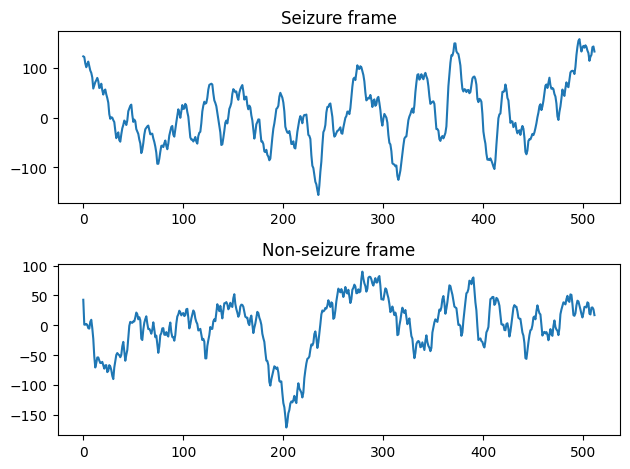

In [67]:
plt.subplot(2,1,1)
plt.plot(seizure_frames[0])
plt.title("Seizure frame")
plt.subplot(2,1,2)
plt.plot(non_seizure_frames[0])
plt.title("Non-seizure frame")
plt.tight_layout()

In [88]:
s_frame_entropy = []
base = 2
bins = 100 # frames are smaller in size
for frame in seizure_frames:
    pk, bins1 = np.histogram(frame, bins=bins, density=True)
    entro = entropy(pk, base=base)
    if entro is np.nan:
        continue
    s_frame_entropy.append(entro)
ns_frame_entropy = []
for frame in non_seizure_frames:
    pk, bins1 = np.histogram(frame, bins=bins, density=True)
    entro = entropy(pk, base=base)
    if entro is np.nan:
        continue
    ns_frame_entropy.append(entro)

/Users/raunavghosh/Documents/Estimation and Detection/Estimation-and-Detection/.venv/lib/python3.9/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/raunavghosh/Documents/Estimation and Detection/Estimation-and-Detection/.venv/lib/python3.9/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


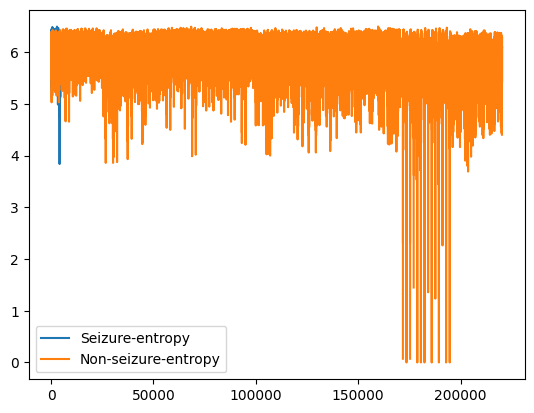

In [89]:
plt.plot(s_frame_entropy, label="Seizure-entropy")
plt.plot(ns_frame_entropy, label="Non-seizure-entropy")
plt.legend()

- The entropy measure of a frame may be used as feature.
- Let me observe the distribution of the entropies.

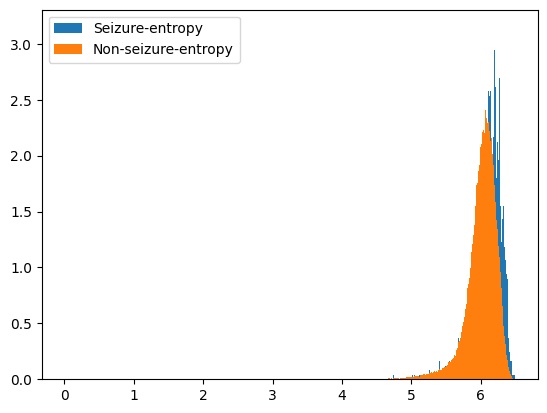

In [107]:
plot_distribution(s_frame_entropy, ns_frame_entropy,
                  data_labels=["Seizure-entropy", "Non-seizure-entropy"])

# Trying to do the same as above but applying an hpf to the data series

In [109]:
from scipy.signal import butter, lfilter, freqz

def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [141]:
# Filter requirements.
order = 2
fs = 256      # sample rate, Hz
cutoff = 120  # desired cutoff frequency of the filter, Hz

seizure_filter = butter_highpass_filter(seizure_data_ft9, cutoff, fs, order)
non_seizure_filter = butter_highpass_filter(non_seizure_data_ft9, cutoff, fs, order)


In [142]:
frame_len = 512
seizure_frames = []
for i in range(0, seizure_filter.shape[0], frame_len):
    seizure_frames.append(seizure_filter[i:i+frame_len])
non_seizure_frames = []
for i in range(0, non_seizure_filter.shape[0], frame_len):
    non_seizure_frames.append(non_seizure_filter[i:i+frame_len])

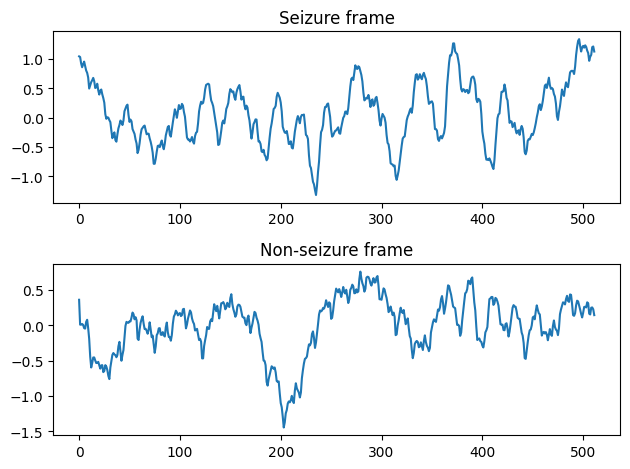

In [143]:
plt.subplot(2,1,1)
plt.plot(seizure_frames[0])
plt.title("Seizure frame")
plt.subplot(2,1,2)
plt.plot(non_seizure_frames[0])
plt.title("Non-seizure frame")
plt.tight_layout()

In [144]:
s_frame_entropy = []
base = 2
bins = 100 # frames are smaller in size
for frame in seizure_frames:
    pk, bins1 = np.histogram(frame, bins=bins, density=True)
    entro = entropy(pk, base=base)
    if entro is np.nan:
        continue
    s_frame_entropy.append(entro)
ns_frame_entropy = []
for frame in non_seizure_frames:
    pk, bins1 = np.histogram(frame, bins=bins, density=True)
    entro = entropy(pk, base=base)
    if entro is np.nan:
        continue
    ns_frame_entropy.append(entro)

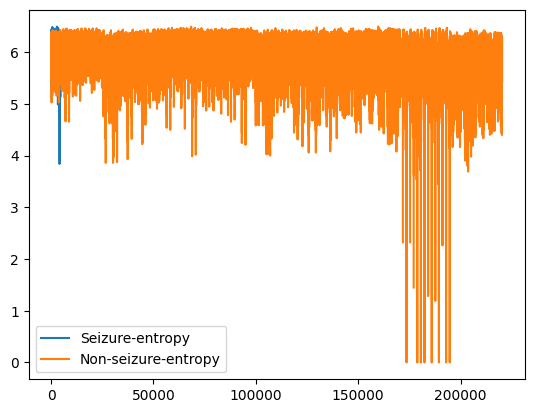

In [145]:
plt.plot(s_frame_entropy, label="Seizure-entropy")
plt.plot(ns_frame_entropy, label="Non-seizure-entropy")
plt.legend()

- The entropy measure of a frame may be used as feature.
- Let me observe the distribution of the entropies.

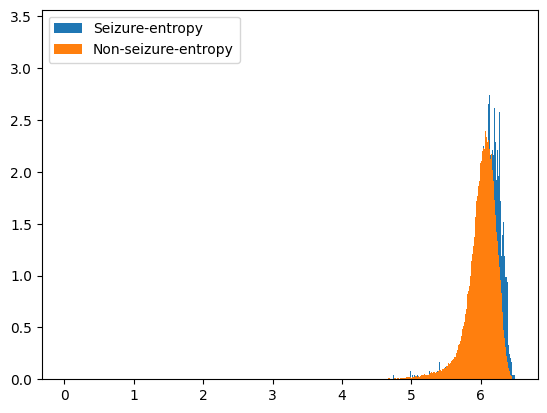

In [146]:
plot_distribution(s_frame_entropy, ns_frame_entropy,
                  data_labels=["Seizure-entropy", "Non-seizure-entropy"])